# Kepler and K2 Planets in the Habitable Zone

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import K2fov
import numpy as np
%matplotlib inline
from tqdm import tqdm
import astropy.units as u
from datetime import datetime
from astropy.coordinates import SkyCoord
from astropy.constants import sigma_sb, G
plt.style.use('ggplot')

We use the models for the habitable zome from Kopparapu 2013. There is a citation for these models below
  

@ARTICLE{HZModel,
   author = {{Kopparapu}, R.~K. and {Ramirez}, R.~M. and {SchottelKotte}, J. and 
	{Kasting}, J.~F. and {Domagal-Goldman}, S. and {Eymet}, V.},
    title = "{Habitable Zones around Main-sequence Stars: Dependence on Planetary Mass}",
  journal = {\apjl},
archivePrefix = "arXiv",
   eprint = {1404.5292},
 primaryClass = "astro-ph.EP",
 keywords = {planets and satellites: atmospheres},
     year = 2014,
    month = jun,
   volume = 787,
      eid = {L29},
    pages = {L29},
      doi = {10.1088/2041-8205/787/2/L29},
   adsurl = {http://adsabs.harvard.edu/abs/2014ApJ...787L..29K},
  adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}

In [2]:
runaway_greenhouse = {'a' : 1.332e-4,
                      'b' : 1.58e-8,
                      'c' : -8.308e-12,
                      'd' : -1.9313e-15,
                    'seff': 1.107}
recent_venus = {'a' : 2.136e-4,
                'b' : 2.533e-8,
                'c' : -1.332e-11,
                'd' : -3.097e-15,
                'seff': 1.776}
maximum_greenhouse = {'a' : 6.171e-5,
                      'b' : 1.698e-9,
                      'c' : -3.198e-12,
                      'd' : -5.575e-16,
                      'seff':0.356}
early_mars = {'a' : 5.547e-5,
              'b' : 1.526e-9,
              'c' : -2.874e-12,
              'd' : -5.011e-16,
              'seff':0.32}

def HZ(ts=5000, dic = runaway_greenhouse):
    dt = ts - 5780
    S = dic['seff'] + dic['a'] * dt + dic['b'] * dt**2 + dic['c'] * dt**3 + dic['d'] * dt**4
    return (S)

def insolation(rs = 0.03, ts=4000, dist=1):
    rs*=u.solRad
    ts*=u.K
    dist*=u.AU
    lum = ((4*np.pi*sigma_sb*(ts**4))*rs**2).to(u.solLum)
    lum = (lum/(1.*u.solLum)).value
    insol = lum * (((1.*u.AU/dist)**2).value)
    return insol

Below we get the data from NExA and clean up any missing values. Sometimes star masses are not given by papers and so are missing from the archive, so we have to fill them in. 

In [3]:
NEXSCI_API = 'http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI'
df = pd.read_csv(NEXSCI_API + '?table=planets&select=pl_hostname,pl_letter,pl_disc,pl_discmethod,ra,dec,pl_trandep,pl_tranflag,pl_orbsmax,pl_radj,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_eqt,pl_orbper,pl_k2flag,pl_kepflag,pl_facility,st_rad,st_teff,st_optmag,st_mass,st_logg', comment='#')
df.to_csv('planets.csv')

df = df[df.pl_tranflag==1].reset_index(drop=True)

#Clean up masses using logg values
inf = ~np.isfinite(df.st_mass)
g = 10.**np.asarray(df.st_logg)*u.cm/u.s**2
mass = (((g*(np.asarray(df.st_rad)*u.solRad)**2)/G).to(u.solMass))
df.loc[inf, 'st_mass'] = mass[inf]

#Clean up masses using models
inf = ~np.isfinite(df.st_mass)
models = pd.read_csv('mamajekmodels.csv')
mok = np.isfinite(models.Msun) & np.isfinite(models.R_Rsun)
df.loc[inf, 'st_mass'] = np.interp(df.st_rad[inf], np.sort(models.R_Rsun[mok]), models.Msun[mok][np.argsort(models.R_Rsun[mok])])

#Clean up temperatures using models
#inf = ~np.isfinite(df.st_teff)
#mok = np.isfinite(models.Msun) & np.isfinite(models.Teff)
df.loc[inf, 'st_teff'] = np.interp(df.st_rad[inf], np.sort(models.R_Rsun[mok]), models.Teff[mok][np.argsort(models.R_Rsun[mok])])


#Clean up semi-major axes
inf = ~np.isfinite(df.pl_orbsmax)
orbsmax = (((np.asarray(df.pl_orbper)*u.day)**2 * G*np.asarray(df.st_mass)*u.solMass / (4 * np.pi**2))**(1./3)).to(u.AU)
df.loc[inf, 'pl_orbsmax'] = orbsmax[inf].value

df['pl_rade'] = (np.asarray(df.pl_radj)*u.jupiterRad).to(u.earthRad)
df['st_t'] = np.asarray(df.st_teff)/5777.
df['pl_a'] = 1./(df.pl_orbsmax**2)
df['pl_insol'] = (df.st_rad)**2 * (df.st_t)**4 * (df.pl_a)
df['pl_eqt'] = np.asarray(df.st_teff)*(np.sqrt(np.asarray(df.st_rad)*u.solRad/(2*(np.asarray(df.pl_orbsmax)*u.AU).to(u.solRad))))

df['habitable'] = (df.pl_insol < HZ(np.asarray(df.st_teff), recent_venus)) & (df.pl_insol > HZ(np.asarray(df.st_teff), early_mars))

k2 = df[(df.pl_k2flag==1)&(df.pl_facility=='K2')].reset_index(drop=True)
kepler = df[(df.pl_kepflag==1)&(df.pl_facility=='Kepler')].reset_index(drop=True)


Now we can build a plot of the habitable zone. 


This figure shows the habitable zone planets discovered by Kepler and K2. Plotted is the insolation of each planet as a function of host star temperature. The insolation is the flux the planet receives, scaled to the flux received at Earth. Point sizes are scaled to the planet radii. Earth, Mars and Venus are plotted as white circles, scaled to their radii. We use planet and stellar parameters given by NExA. Where NExA stellar mass values are unavailable, these are generated using either NExA stellar log(g) and stellar radius measurements, or stellar radii and stellar models from Pecaut & Mamajek (2013) [ApJS, 208, 9]. This plot only shows **confirmed** planets **discovered** by Kepler and K2 (i.e. NExA `pl_facility` is Kepler or K2). Additionally, this plot only shows small planets with radius measurements < 2 $R_{earth}$. We use the Kopparapu et al 2013 models for the habitable zone regions. In light green is the 'optimistic' habitable zone based on the recent Venus and early Mars habitbility scenarios from that work. In dark green is the "conservative" habitable zone; the inner edge is set by a runaway greenhouse effect and the outer edge is set by the maximum greenhouse effect. Some planets have moved compared to previous versions of this plot due to updated stellar temperature estimates, which also affect the planet insolation estimate.

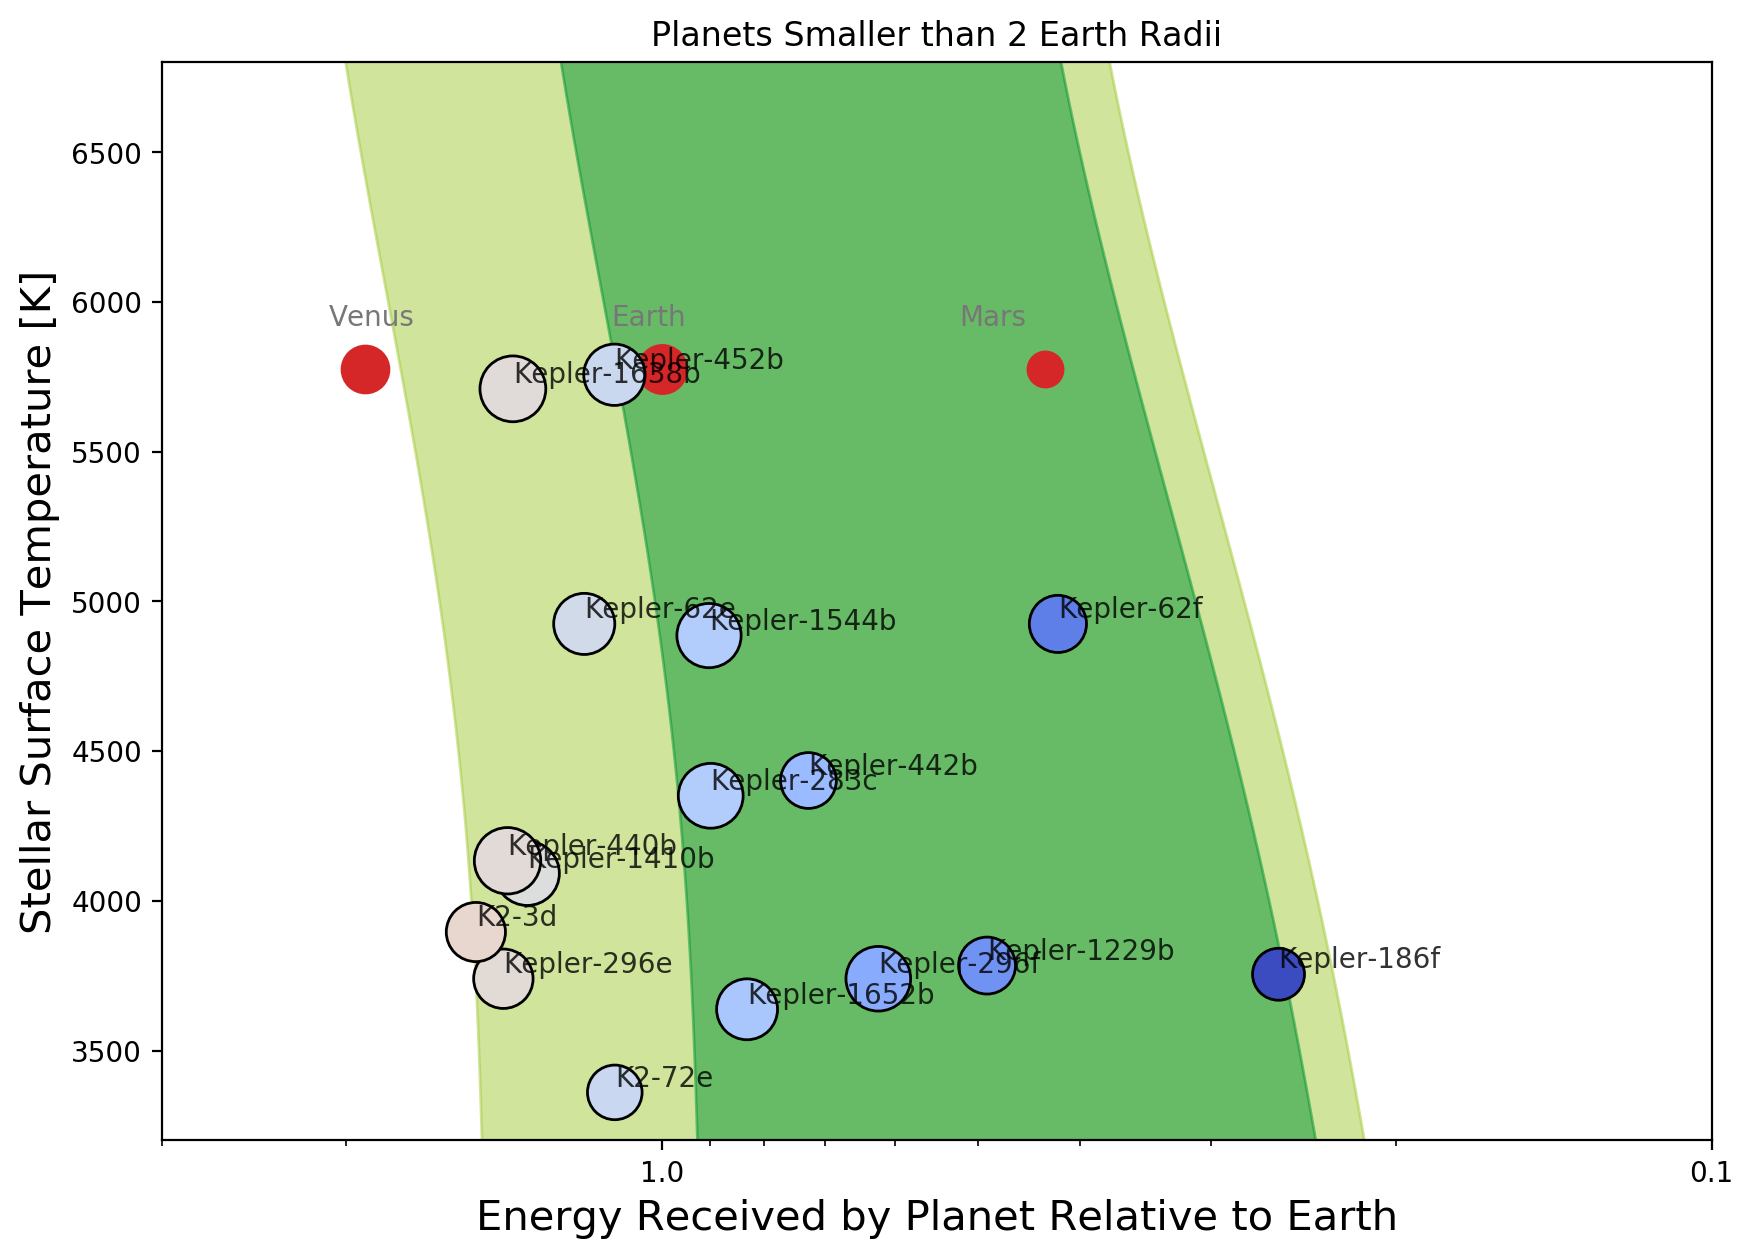

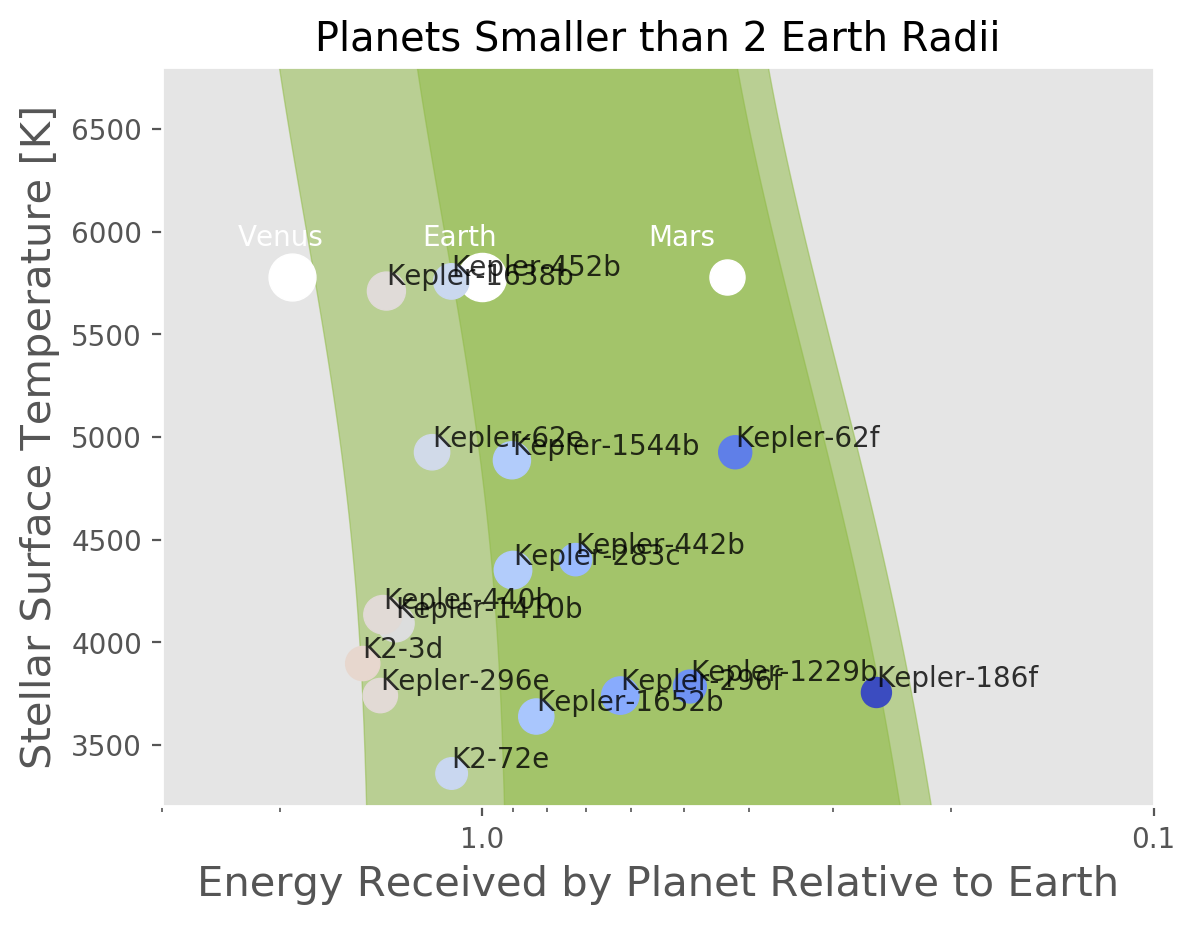

In [15]:
def hzplot(ax=None, figsize=(10,7), scale = 300, eps=False):
    planetcolor='white'
    if eps:
         planetcolor='C3'
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ts = np.arange(1500,10000, 10)
    if eps:
        ax.fill_betweenx(ts, HZ(ts, recent_venus), HZ(ts, early_mars), alpha=0.5, color='#A3CB38', zorder=-10)
        ax.fill_betweenx(ts, HZ(ts, runaway_greenhouse), HZ(ts, maximum_greenhouse), alpha=0.5, color='#009432', zorder=-9)
    else:
        ax.fill_betweenx(ts, HZ(ts, recent_venus), HZ(ts, early_mars), alpha=0.5, color='C5', zorder=-10)
        ax.fill_betweenx(ts, HZ(ts, runaway_greenhouse), HZ(ts, maximum_greenhouse), alpha=0.5, color='C5', zorder=-9)


    ax.set_xlim(3, 0.1)
    ax.set_xscale('log')
    ax.set_ylim(3200, 6800)
    ax.set_xlabel('Energy Received by Planet Relative to Earth', fontsize=15)
    ax.set_ylabel('Stellar Surface Temperature [K]', fontsize=15)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    plt.scatter(1, 5777, s=scale, color=planetcolor)
    plt.text(0.95, 5900, 'Earth', ha='right', va='bottom', color=planetcolor)

    plt.scatter(insolation(1, 5777, 1.524), 5777, s=scale*(2106/3959), color=planetcolor)
    plt.text(0.45, 5900, 'Mars', ha='right', va='bottom', color=planetcolor)

    plt.scatter(insolation(1, 5777, 0.723), 5777, s=scale*(3760/3959), color=planetcolor)
    plt.text(1.72, 5900, 'Venus', ha='right', va='bottom', color=planetcolor)

    plt.grid(False)

    return ax




def plot(Mission='Kepler', RadiusLimit = 2, Year=2020, ax=None, legend=False, scale = 300, edgecolor=None, eps=False):
    dics = {'Kepler': kepler, 'K2': k2}
    df = dics[Mission]
    if ax is None:
        ax = hzplot(ax, scale=scale, eps=eps)
    ok = np.isfinite(df.pl_insol) & (df.pl_rade < RadiusLimit) & (df.pl_disc<Year) & (df.habitable)
    plt.scatter(df.pl_insol[ok], df.st_teff[ok], s=df.pl_rade[ok]*scale, c=df.pl_eqt[ok], cmap=plt.get_cmap('coolwarm'), vmin=200, vmax=400, label=Mission, edgecolor=edgecolor)
    for x, y, z in zip(df[ok].pl_insol, df[ok].st_teff, df[ok].pl_hostname+df[ok].pl_letter):
        plt.text(x, y, '{}'.format(z), ha='left', va='bottom', color='black', alpha=0.8)
    plt.title("Planets Smaller than {} Earth Radii".format(RadiusLimit))
    if legend:
        lg = plt.legend(loc='upper left')
        for l in lg.legendHandles:
            l._sizes=[20]
    return ax
    
plt.style.use('default')
ax = hzplot(eps=True)
ax = plot('Kepler', ax=ax, edgecolor='black')
ax = plot('K2', ax=ax, edgecolor='black')
plt.axis('on')
plt.savefig('charts/smallplanets_HZ.eps', dpi=300, bbox_inches='tight')

    
plt.style.use('ggplot')
ax = hzplot(figsize=(6.4,4.8))
ax = plot('Kepler', ax=ax, scale=100)
ax = plot('K2', ax=ax, scale=100)

plt.savefig('charts/smallplanets_HZ.png', dpi=300, bbox_inches='tight')


You can have fun playing with the widget below.

In [5]:
from ipywidgets import interactive, fixed


interactive_plot = interactive(plot, Mission=['Kepler', 'K2'], RadiusLimit = (0., 10., 0.2), Year=(2010, 2018, 1), ax=fixed(None), legend=fixed(True), scale=fixed(300), edgecolor=fixed(None), eps=fixed(False))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot


interactive(children=(Dropdown(description='Mission', options=('Kepler', 'K2'), value='Kepler'), FloatSlider(value=2.0, description='RadiusLimit', max=10.0, step=0.2), IntSlider(value=2018, description='Year', max=2018, min=2010), Output(layout=Layout(height='700px'))), _dom_classes=('widget-interact',))

Here are the values for the Kepler and K2 planets

In [6]:
df = kepler
ok = np.isfinite(df.pl_insol) & (df.pl_rade < 2) & (df.pl_disc<2020) & (df.habitable)
df[ok][['pl_hostname','pl_letter','pl_insol','st_teff','pl_rade']].reset_index(drop=True)

,pl_hostname,pl_letter,pl_insol,st_teff,pl_rade
0,Kepler-62,f,0.419688,4925.0,1.412332
1,Kepler-1410,b,1.344740,4092.0,1.782228
2,Kepler-296,e,1.417053,3740.0,1.524421
3,Kepler-1544,b,0.902417,4886.0,1.782228
4,Kepler-442,b,0.725515,4402.0,1.345078
5,Kepler-62,e,1.186642,4925.0,1.614093
6,Kepler-440,b,1.404164,4134.0,1.905527
7,Kepler-1638,b,1.387757,5710.0,1.871900
8,Kepler-283,c,0.899058,4351.0,1.815855
9,Kepler-452,b,1.110601,5757.0,1.625302


In [7]:
df = k2
ok = np.isfinite(df.pl_insol) & (df.pl_rade < 2) & (df.pl_disc<2020) & (df.habitable)
df[ok][['pl_hostname','pl_letter','pl_insol','st_teff','pl_rade']].reset_index(drop=True)

,pl_hostname,pl_letter,pl_insol,st_teff,pl_rade
0,K2-3,d,1.505177,3896.00,1.513212
1,K2-72,e,1.109703,3360.47,1.289033
